In [1]:
import torch
import torch.nn as nn
from torchsummary import summary

import pandas as pd
import plotly.express as px
from time import time
from sklearn import metrics

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TIMESTEPS = 1500
LEAD_COUNT = 12

EPOCHS=30
BATCH_SIZE=32
LEARNING_RATE=8e-6

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataset = torch.load("drive/MyDrive/dataset3.pt")

split_size = list()
split_size.append(int(0.64*len(dataset)))
split_size.append(int(0.16*len(dataset)))
split_size.append(len(dataset)-sum(split_size))

datasets = torch.utils.data.random_split(dataset, split_size)

In [5]:
dataloaders = [torch.utils.data.DataLoader(i, batch_size=b, shuffle=True) for i, b in zip(datasets, [BATCH_SIZE]*3)]

In [6]:
class ECGNN(nn.Module):
    def __init__(self):
        super(ECGNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 16, (3, 100), padding=1),
            nn.Conv2d(16, 16, (3, 100), padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, (3, 100), padding=1),
            nn.Conv2d(32, 32, (3, 100), padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, (3, 100))
        )
        self.lin_block = nn.Sequential(
            nn.Linear(4160, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
    
    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x, 1)
        x = self.lin_block(x)
        x = torch.sigmoid(x)
        return x

In [7]:
def train(model, loss, maeloss, mseloss, optimizer, data):
    global ypred
    global x
    nbat = len(data)
    aloss, aacc, amloss, amsloss, aauc = 0, 0, 0,0,0
    for batch, (x, y) in enumerate(data):
        x = x.to(device = DEVICE, dtype=torch.float)
        y = y.to(device = DEVICE, dtype=torch.float)
        ypred = model(x)
        bloss = loss(ypred ,y)
        
        optimizer.zero_grad()
        bloss.backward()
        optimizer.step()

        with torch.no_grad():
            #acc = ((ypred.squeeze()>=0.50).int()==y).sum().item()/BATCH_SIZE
            fpr, tpr, thresholds = metrics.roc_curve(y.cpu().numpy(), ypred.cpu().squeeze().numpy())
            auc = metrics.auc(fpr, tpr)
            bloss = loss(ypred, y)
            mloss = maeloss(ypred, y).item()
            msloss = mseloss(ypred, y).item()
            amloss += mloss
            amsloss += msloss
            aloss += bloss.item()
            aauc += auc
            #aacc += acc


        print("Train - crossentropy_loss: %f  mae_loss:%f  mse_loss: %f  auc %f  [%d/%d]"%(bloss.item(), mloss, msloss, auc, batch+1, nbat), end="\r")
    aloss /= nbat
    #aacc /= nbat
    aauc /= nbat
    amloss /= nbat
    amsloss /= nbat
    print("\nTrain - crossentropy_loss: %f  mae_loss: %f  mse_loss: %f  auc: %f  [Average]"%(aloss, amloss, amsloss, aauc))
    return (aloss, amloss, amsloss, aauc)

In [8]:
def test(model, loss, maeloss, mseloss, data):
    nbat = len(data)
    auc, bloss, mloss, msloss = 0, 0, 0, 0

    with torch.no_grad():
        for x, y in data:
            x = x.to(device=DEVICE, dtype=torch.float)
            y = y.to(device=DEVICE, dtype=torch.float)
            ypred = model(x)
            bloss += loss(ypred ,y)
            mloss += maeloss(ypred ,y).item()
            msloss += mseloss(ypred, y).item()
            #acc += ((ypred.squeeze()>=0.50).int()==y).sum().item()/BATCH_SIZE
            fpr, tpr, thresholds = metrics.roc_curve(y.cpu().numpy(), ypred.cpu().squeeze().numpy())
            auc += metrics.auc(fpr, tpr)
    
    #acc /= nbat
    auc /= nbat
    bloss /= nbat
    mloss /= nbat
    msloss /= nbat
    print("Test - crossentropy_loss: %f  mae_loss: %f  mse_loss: %f  auc: %f"%(bloss.item(), mloss, msloss, auc))
    return (bloss.item(), mloss, msloss, auc)

In [9]:
def fit(model, loss, mloss, msloss, optimizer, train_loader, test_loader, epochs):
    train_history = {
        "epochs": list(range(1, epochs+1)),
        "crossentropy_loss": list(),
        "mae_loss": list(),
        "mse_loss": list(),
        "auc": list()
    }
    test_history = {
        "epochs": list(range(1, epochs+1)),
        "crossentropy_loss": list(),
        "mae_loss": list(),
        "mse_loss": list(),
        "auc": list()
    }
    for e in range(epochs):
        print("EPOCH %d/%d"%(e+1, epochs))

        l, m, ms, auc = train(model, loss, mloss, msloss, optimizer, train_loader)
        train_history["crossentropy_loss"].append(l)
        train_history["mae_loss"].append(m)
        train_history["mse_loss"].append(ms)
        train_history["auc"].append(auc)

        l, m, ms, auc = test(model, loss, mloss, msloss, test_loader)
        test_history["crossentropy_loss"].append(l)
        test_history["mae_loss"].append(m)
        test_history["mse_loss"].append(ms)
        test_history["auc"].append(auc)

        print("\n--------------------\n")
    return {
        "train": train_history,
        "test": test_history
    }

In [10]:
model = ECGNN().to(DEVICE)
summary(model, (1, 12, 1500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 12, 1403]           4,816
            Conv2d-2         [-1, 16, 12, 1306]          76,816
         MaxPool2d-3           [-1, 16, 6, 653]               0
            Conv2d-4           [-1, 32, 6, 556]         153,632
            Conv2d-5           [-1, 32, 6, 459]         307,232
         MaxPool2d-6           [-1, 32, 3, 229]               0
            Conv2d-7           [-1, 32, 1, 130]         307,232
            Linear-8                 [-1, 1024]       4,260,864
              ReLU-9                 [-1, 1024]               0
           Linear-10                  [-1, 512]         524,800
             ReLU-11                  [-1, 512]               0
           Linear-12                    [-1, 1]             513
Total params: 5,635,905
Trainable params: 5,635,905
Non-trainable params: 0
---------------------------

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss = nn.BCELoss()
mloss = nn.L1Loss(reduction="mean")
msloss = nn.MSELoss()

In [12]:
history = fit(model, loss, mloss, msloss, optimizer, dataloaders[0], dataloaders[1], EPOCHS)

EPOCH 1/30
Train - crossentropy_loss: 0.104247  mae_loss:0.095120  mse_loss: 0.015461  auc 1.000000  [444/444]
Train - crossentropy_loss: 0.506835  mae_loss: 0.351266  mse_loss: 0.170807  auc: 0.809336  [Average]
Test - crossentropy_loss: 0.328046  mae_loss: 0.192538  mse_loss: 0.096950  auc: 0.009009

--------------------

EPOCH 2/30
Train - crossentropy_loss: 0.119210  mae_loss:0.109176  mse_loss: 0.017382  auc 1.000000  [444/444]
Train - crossentropy_loss: 0.286214  mae_loss: 0.176064  mse_loss: 0.085536  auc: 0.952305  [Average]
Test - crossentropy_loss: 0.260571  mae_loss: 0.152262  mse_loss: 0.076727  auc: 0.009009

--------------------

EPOCH 3/30
Train - crossentropy_loss: 0.184699  mae_loss:0.148057  mse_loss: 0.049823  auc 1.000000  [444/444]
Train - crossentropy_loss: 0.235096  mae_loss: 0.144189  mse_loss: 0.069314  auc: 0.967514  [Average]
Test - crossentropy_loss: 0.212757  mae_loss: 0.133138  mse_loss: 0.061539  auc: 0.008348

--------------------

EPOCH 4/30
Train - cro

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


Test - crossentropy_loss: 0.107312  mae_loss: 0.056953  mse_loss: 0.030664  auc: 0.009009

--------------------

EPOCH 17/30
Train - crossentropy_loss: 0.004770  mae_loss:0.004733  mse_loss: 0.000073  auc 1.000000  [444/444]
Train - crossentropy_loss: 0.073082  mae_loss: 0.044671  mse_loss: 0.020966  auc: 0.997060  [Average]
Test - crossentropy_loss: 0.104437  mae_loss: 0.056129  mse_loss: 0.030260  auc: 0.009009

--------------------

EPOCH 18/30
Train - crossentropy_loss: 0.110505  mae_loss:0.093409  mse_loss: 0.027000  auc 1.000000  [444/444]
Train - crossentropy_loss: 0.067980  mae_loss: 0.041524  mse_loss: 0.019389  auc: 0.997277  [Average]
Test - crossentropy_loss: 0.109999  mae_loss: 0.056103  mse_loss: 0.032073  auc: 0.008946

--------------------

EPOCH 19/30
Train - crossentropy_loss: 0.024406  mae_loss:0.023436  mse_loss: 0.001819  auc 1.000000  [444/444]
Train - crossentropy_loss: 0.062403  mae_loss: 0.038765  mse_loss: 0.017438  auc: 0.998293  [Average]
Test - crossentropy

In [13]:
px.line(pd.DataFrame(history["train"]))

In [22]:
px.line(pd.DataFrame(history["test"]))

In [15]:
torch.save(model.state_dict(), f"drive/MyDrive/model{int(time())}.pt")

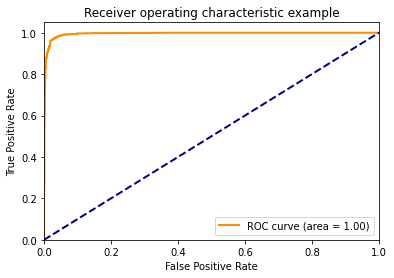

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
yt = list()
yp = list()
with torch.no_grad():
    for x, y in dataloaders[2]:
        yt.append(y)
        yp.append(model(x.to(device=DEVICE, dtype=torch.float)).cpu())

yt = torch.cat(yt).squeeze()
yp = torch.cat(yp).squeeze()

fpr, tpr, _ = roc_curve(yt, yp)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=2,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.savefig("drive/MyDrive/roc_test.png", dpi=300)
plt.show()


In [23]:
yp

tensor([2.1759e-13, 8.9220e-13, 9.9995e-01,  ..., 2.2170e-05, 9.9991e-01,
        1.0000e+00])